In [1]:
#Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#Setting up the working directory

os.chdir("E:\PGP AIML\Projects\Recommender Systems")

In [3]:
#Importing Data

df = pd.read_csv('ratings_Electronics.csv', sep=',',header=None)

In [4]:
#Assigning Column Names

df.columns = ['userid','prodid','rating','timestamp']

In [5]:
#Sample rows and shape of the dataset. 7.8M rows in the dataset.

df.sample(5)

df.shape

,userid,prodid,rating,timestamp
3520095,A1OWOSM637HL0J,B003QVWJM2,5.0,1325116800
6314207,A2WGM7BEGWIQK4,B008OEHPPM,4.0,1366156800
3856635,A2QW24GBT3UTXU,B00443BDHS,5.0,1396915200
7723639,A1558M458N7LVZ,B00GUZEZL4,5.0,1389916800
2179155,A2RDX6RR5JIJVS,B001NPEBEC,5.0,1385856000


(7824482, 4)

In [6]:
df.isna().sum()

#No null values in the entire dataset

userid       0
prodid       0
rating       0
timestamp    0
dtype: int64

In [7]:
# Dropping time stamp column as we are not going to use it

df = df.drop(['timestamp'], axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userid    object
prodid    object
rating    float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [9]:
df.describe(include='all').transpose()

#476K unique products and 4.2M unique users

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
userid,7824482,4201696,A5JLAU2ARJ0BO,520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prodid,7824482,476002,B0074BW614,18244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,7.82448e+06,NaN,NaN,NaN,4.01234,1.38091,1,3,5,5,5


5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: rating, dtype: int64

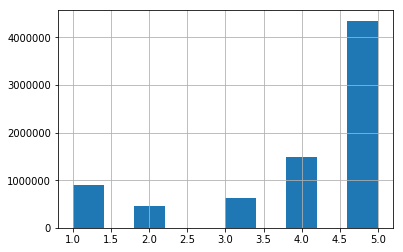

In [10]:
df['rating'].hist()
df['rating'].value_counts()

#Most of the ratings are 5's

In [11]:
df['prodid'].nunique()
df['userid'].nunique()

#476K unique products and 4.2M unique users

476002

4201696

In [12]:
#Building popularity recommender model. Creating a dataset which has products and their purchase counts

popular_products = pd.DataFrame(df.groupby('prodid')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.columns = ['count']
most_popular.head(10)

#This dataset shows product - B0074BW614 was bought 18,244 times. 
#The next most popular product is B00DR0PDNE which was bought 16,454 times 

,count
prodid,
B0074BW614,18244
B00DR0PDNE,16454
B007WTAJTO,14172
B0019EHU8G,12285
B006GWO5WK,12226
B003ELYQGG,11617
B003ES5ZUU,10276
B007R5YDYA,9907
B00622AG6S,9823


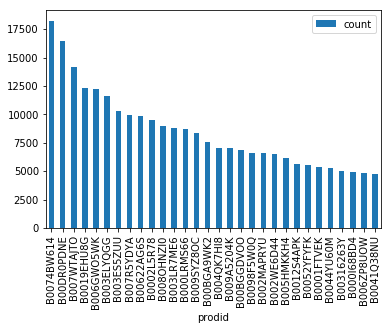

In [13]:
#Chart below shows top 30 most popular products

#If a new user joins the site, we can go ahead and show the most popular 'n' number of products to him 
#'n' can be decided based on business needs

most_popular.head(30).plot(kind = "bar")

In [14]:
#Group new data by product
#Creating this dataset to filter out customers who gave less than 50 ratings and make the dataset less sparse

user_groupby = df.groupby('userid',as_index=False)
user_review_count = user_groupby['prodid'].count()
user_review_count.columns = ['userid','count']

user_review_count.head()

,userid,count
0,A00000262KYZUE4J55XGL,1
1,A000063614T1OE0BUSKUT,2
2,A00009182QVLSWIGHLS1B,1
3,A00009661LC9LQPGKJ24G,1
4,A00010809P09NUU6ZP6H,1


In [15]:
#dataset with users who gave more than 50 ratings

users_50 = user_review_count.loc[user_review_count['count']>50]

In [16]:
#subset of main dataset which contains only those users we filtered above

ratings = df.loc[df['userid'].isin(users_50['userid'])]

In [17]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122171 entries, 118 to 7824444
Data columns (total 3 columns):
userid    122171 non-null object
prodid    122171 non-null object
rating    122171 non-null float64
dtypes: float64(1), object(2)
memory usage: 3.7+ MB


In [18]:
#converting data into surprise format

from surprise import Dataset,Reader
reader = Reader(rating_scale=(1, 5))

In [19]:
data = Dataset.load_from_df(ratings[['userid', 'prodid', 'rating']], reader)

E:\Anaconda\lib\site-packages\scikit_surprise-1.0.6-py3.7-win-amd64.egg\surprise\dataset.py:61: UserWarning: Using rating_scale from reader, deprecated. Set rating_scale at dataset creation instead (load_from_file, load_from_folds, or load_from_df).
  warnings.warn('Using rating_scale from reader, deprecated. Set '


In [21]:
#Split data to train and test

from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.30,random_state=123)

In [22]:
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import GridSearchCV

In [23]:
#creating a parameter grid for SVD

params_grid = {'n_factors':[1,3,5],'reg_all': [0.01, 0.02]}

In [24]:
gridsearch=GridSearchCV(SVD, params_grid,measures=['rmse'],cv=10,refit=True)

In [25]:
gridsearch.fit(data)

In [26]:
gridsearch.cv_results
gridsearch.best_params
gridsearch.best_score

{'split0_test_rmse': array([0.96607001, 0.96599742, 0.96587113, 0.96582159, 0.96629304,
        0.96621546]),
 'split1_test_rmse': array([0.98036279, 0.98037681, 0.98047499, 0.98059005, 0.98040513,
        0.9805752 ]),
 'split2_test_rmse': array([0.97859427, 0.97856748, 0.97896869, 0.97882017, 0.97883937,
        0.97892717]),
 'split3_test_rmse': array([0.96027727, 0.96034513, 0.96063875, 0.96081699, 0.96108194,
        0.96046274]),
 'split4_test_rmse': array([0.97529099, 0.97471658, 0.97582255, 0.97536516, 0.97602309,
        0.97520535]),
 'split5_test_rmse': array([0.98090563, 0.98075781, 0.98083821, 0.98106592, 0.98160066,
        0.98149525]),
 'split6_test_rmse': array([0.97314389, 0.97265464, 0.97308113, 0.9733846 , 0.97343186,
        0.97320308]),
 'split7_test_rmse': array([0.97676352, 0.9762242 , 0.97650358, 0.97663516, 0.97728747,
        0.9764051 ]),
 'split8_test_rmse': array([0.96664598, 0.96651469, 0.966752  , 0.96681986, 0.96666248,
        0.96678048]),
 'split9_t

{'rmse': {'n_factors': 1, 'reg_all': 0.02}}

{'rmse': 0.9719853665522553}

In [27]:
#predicting on test set

pred=gridsearch.test(testset)

In [28]:
#converting predictions into dataframe

pred_df = pd.DataFrame([[x.uid,x.iid,x.est] for x in pred])

In [29]:
pred_df.head()

,0,1,2
0,A2NT3W1F1XYBFZ,B002LITT56,4.661950
1,A2MCRCK1V61FWQ,B0042RUSY0,4.928196
2,AOWF9T81XMX2S,B0002LEMWE,4.750292
3,A1Z7U9K6X3FEOU,B00845RYXE,4.301206
4,A200DY76VXVGP9,B009CP99GK,4.942896


In [30]:
#Assigning column names to prediction dataset and also sorting them on users

pred_df.columns = ["userId","ProdId","est_rating"]
pred_df.sort_values(by = ["userId", "est_rating"],ascending=False,inplace=True)

In [36]:
pred_df.head(10)

,userId,ProdId,est_rating
1189,AZOK5STV85FBJ,B005PQTYHE,5.000000
31496,AZOK5STV85FBJ,B0002L5R78,4.921494
26027,AZOK5STV85FBJ,B00B25P27S,4.855734
2464,AZOK5STV85FBJ,B003ES5ZSW,4.846775
31896,AZOK5STV85FBJ,B00005854B,4.834521
25351,AZOK5STV85FBJ,B000GL3MOY,4.765559
5205,AZOK5STV85FBJ,B0002BA570,4.764278
5187,AZOK5STV85FBJ,B00BF6HVG4,4.751525
24172,AZOK5STV85FBJ,B0007OWNYA,4.726197
29180,AZOK5STV85FBJ,B000FFT2KE,4.720293


In [32]:
#selecting only top 5 recommendations for all users

top_5_recommendations = pred_df.groupby("userId").head(5).reset_index(drop=True)

In [33]:
top_5_recommendations.head(5)

,userId,ProdId,est_rating
0,AZOK5STV85FBJ,B005PQTYHE,5.000000
1,AZOK5STV85FBJ,B0002L5R78,4.921494
2,AZOK5STV85FBJ,B00B25P27S,4.855734
3,AZOK5STV85FBJ,B003ES5ZSW,4.846775
4,AZOK5STV85FBJ,B00005854B,4.834521


In [34]:
#Accuracy of the model

accuracy.rmse(pred)

RMSE: 0.8856


0.8855512748185588

In [37]:
#Popularity based model is useful in a e-commerce website when the users sign up for the first time and there is no 
#purchase/rating history to start with. 

#As customers start buying products, recommendation engine can use the collaborative filtering technique for 
#better recommendations